In [9]:
import os,random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import numpy as np
from src.dataset2016 import load_data
from statistics import mean
from src.utils import *

### Set Random Seed

In [3]:
seed = 1994
random.seed(seed)  
np.random.seed(seed) 
tf.random.set_seed(seed)

### Read Dataset

In [4]:
'''
In dataset RML2016.10a, for each modulation type each snr, there're 1000 samples.
We use radnomly select 750 samples as training data (unlabled) adn 250 as testing.
As lableded dataset, in this experiment, we use size_train_labeled = 2 as training set
and size_val_labeled = 1 as validation set.
'''
size_train_labeled = 2 # [0,1000], # of labeled training samples
size_val_labeled = 1   # [0,1000], # of labeled validation samples

# Read dataset
filename = '/data/dongxin3/2016.10a/RML2016.10a_dict.pkl'
(mods,snrs,lbl),(X_train,Y_train),(X_train_labeled,Y_train_labeled),(X_val_labeled,Y_val_labeled),(X_test,Y_test),\
    (train_idx,test_idx,train_labeled_idx,val_labeled_idx)\
    = load_data(filename, size_train_labeled, size_val_labeled)

# Normalization
X_train, X_train_labeled, X_val_labeled, X_test = normalize_data(X_train, X_train_labeled, X_val_labeled, X_test)

print("# of all training data:", X_train.shape[0])
print("# of all testing data:", X_test.shape[0])
print("# of labeled data:", X_train_labeled.shape[0]+X_val_labeled.shape[0], \
      "( Training:",X_train_labeled.shape[0], "Validation:",X_val_labeled.shape[0],")")

# of all training data: 165000
# of all testing data: 55000
# of labeled data: 660 ( Training: 440 Validation: 220 )


### Train Contrastive Learning Model - Simclr

In [4]:
# SimLCR
sim_model, epoch_losses = train_simclr(X_train, batch_size=512, Epoch=100, temperature = 0.1)

Model: "model_simclr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 105, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)          

### Show Epoch Loss Curve

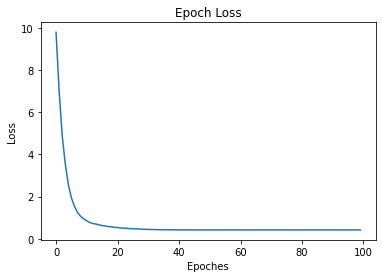

In [5]:
plot_epoch_loss()

### Build a classifier on the output of the encoder and tune the parameter of the encoder with labeled data

In [15]:
# Tune Model
tune_model = train_tune(X_train_labeled, Y_train_labeled, X_val_labeled, Y_val_labeled)

Model: "Tune_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 105, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           1

Epoch 32/200
1/1 - 0s - loss: 1.7294 - accuracy: 0.3591 - val_loss: 1.7735 - val_accuracy: 0.3455

Epoch 00032: val_loss improved from 1.78063 to 1.77351, saving model to ./saved_models/weight_tune.hdf5
Epoch 33/200
1/1 - 0s - loss: 1.7389 - accuracy: 0.3886 - val_loss: 1.7651 - val_accuracy: 0.3455

Epoch 00033: val_loss improved from 1.77351 to 1.76512, saving model to ./saved_models/weight_tune.hdf5
Epoch 34/200
1/1 - 0s - loss: 1.7213 - accuracy: 0.3727 - val_loss: 1.7588 - val_accuracy: 0.3591

Epoch 00034: val_loss improved from 1.76512 to 1.75884, saving model to ./saved_models/weight_tune.hdf5
Epoch 35/200
1/1 - 0s - loss: 1.6791 - accuracy: 0.3795 - val_loss: 1.7581 - val_accuracy: 0.3636

Epoch 00035: val_loss improved from 1.75884 to 1.75806, saving model to ./saved_models/weight_tune.hdf5
Epoch 36/200
1/1 - 0s - loss: 1.6724 - accuracy: 0.3886 - val_loss: 1.7529 - val_accuracy: 0.3864

Epoch 00036: val_loss improved from 1.75806 to 1.75293, saving model to ./saved_models/we


Epoch 00079: val_loss did not improve from 1.69065
Epoch 80/200
1/1 - 0s - loss: 1.4700 - accuracy: 0.4886 - val_loss: 1.7164 - val_accuracy: 0.3818

Epoch 00080: val_loss did not improve from 1.69065
Epoch 81/200
1/1 - 0s - loss: 1.4485 - accuracy: 0.5023 - val_loss: 1.7088 - val_accuracy: 0.3955

Epoch 00081: val_loss did not improve from 1.69065
Epoch 82/200
1/1 - 0s - loss: 1.4794 - accuracy: 0.4705 - val_loss: 1.7080 - val_accuracy: 0.3955

Epoch 00082: val_loss did not improve from 1.69065
Epoch 83/200
1/1 - 0s - loss: 1.4168 - accuracy: 0.5091 - val_loss: 1.7048 - val_accuracy: 0.4000

Epoch 00083: val_loss did not improve from 1.69065
Epoch 84/200
1/1 - 0s - loss: 1.4592 - accuracy: 0.4977 - val_loss: 1.7012 - val_accuracy: 0.4091

Epoch 00084: val_loss did not improve from 1.69065

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0025599997490644458.
Epoch 85/200
1/1 - 0s - loss: 1.4580 - accuracy: 0.4705 - val_loss: 1.7023 - val_accuracy: 0.4045

Epoch 00085: val_l

### Train the encoder + classifier from the very beginning under supervised way

In [16]:
sup_model = train_supervised(X_train_labeled, Y_train_labeled, X_val_labeled, Y_val_labeled)

Model: "Sup_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I/Qchannel (InputLayer)      [(None, 128, 2)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 105, 32)           1568      
_________________________________________________________________
LSTM1 (LSTM)                 (None, 105, 128)          82432     
_________________________________________________________________
dropout_12 (Dropout)         (None, 105, 128)          0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 105, 128)          131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 105, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 128)           13

Epoch 36/500
1/1 - 0s - loss: 1.8310 - accuracy: 0.3591 - val_loss: 1.8648 - val_accuracy: 0.2864

Epoch 00036: val_loss improved from 1.86990 to 1.86481, saving model to ./saved_models/weight_sup.hdf5
Epoch 37/500
1/1 - 0s - loss: 1.7746 - accuracy: 0.3523 - val_loss: 1.8651 - val_accuracy: 0.2864

Epoch 00037: val_loss did not improve from 1.86481
Epoch 38/500
1/1 - 0s - loss: 1.7814 - accuracy: 0.3659 - val_loss: 1.8517 - val_accuracy: 0.2955

Epoch 00038: val_loss improved from 1.86481 to 1.85174, saving model to ./saved_models/weight_sup.hdf5
Epoch 39/500
1/1 - 0s - loss: 1.7352 - accuracy: 0.3750 - val_loss: 1.8596 - val_accuracy: 0.3136

Epoch 00039: val_loss did not improve from 1.85174
Epoch 40/500
1/1 - 0s - loss: 1.7646 - accuracy: 0.3500 - val_loss: 1.8556 - val_accuracy: 0.3091

Epoch 00040: val_loss did not improve from 1.85174
Epoch 41/500
1/1 - 0s - loss: 1.7899 - accuracy: 0.3409 - val_loss: 1.8614 - val_accuracy: 0.2909

Epoch 00041: val_loss did not improve from 1.85

### Compare the result of our model and the supervised training results

108/108 [==============================] - 2s 12ms/step - loss: 1.7067 - accuracy: 0.4007
Tuned model score: [1.7067266702651978, 0.4007454514503479]
108/108 [==============================] - 2s 12ms/step - loss: 1.8600 - accuracy: 0.3259
Supervised model score: [1.8600481748580933, 0.3258908987045288]


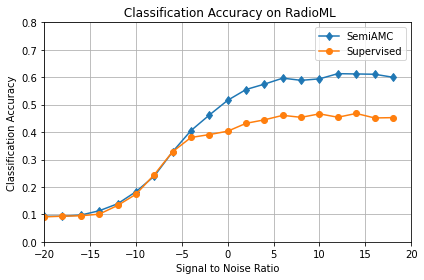

In [17]:
weight_tune = "./saved_models/weight_tune.hdf5"
weight_sup = "./saved_models/weight_sup.hdf5"

compare_tune_and_sup(weight_tune, weight_sup, X_test, Y_test, test_idx, snrs, lbl)